# Gerando texto com uma rede recorrente simples.

Vamos ler os documentos do corpus `reuters`. Precisamos tambem converter os labels em inteiros para trabalhar com TensorFlow.

In [1]:
from nltk.corpus import reuters

cats = reuters.categories()
cat_to_label = {cat: label for cat, label in zip(cats, range(len(cats)))}

docs = []
labels = []
for fileid in reuters.fileids():
    doc = reuters.raw(fileid)
    for cat in reuters.categories(fileid):
        docs.append(doc)
        labels.append(cat_to_label[cat])

In [2]:
print(cat_to_label)

{'acq': 0, 'alum': 1, 'barley': 2, 'bop': 3, 'carcass': 4, 'castor-oil': 5, 'cocoa': 6, 'coconut': 7, 'coconut-oil': 8, 'coffee': 9, 'copper': 10, 'copra-cake': 11, 'corn': 12, 'cotton': 13, 'cotton-oil': 14, 'cpi': 15, 'cpu': 16, 'crude': 17, 'dfl': 18, 'dlr': 19, 'dmk': 20, 'earn': 21, 'fuel': 22, 'gas': 23, 'gnp': 24, 'gold': 25, 'grain': 26, 'groundnut': 27, 'groundnut-oil': 28, 'heat': 29, 'hog': 30, 'housing': 31, 'income': 32, 'instal-debt': 33, 'interest': 34, 'ipi': 35, 'iron-steel': 36, 'jet': 37, 'jobs': 38, 'l-cattle': 39, 'lead': 40, 'lei': 41, 'lin-oil': 42, 'livestock': 43, 'lumber': 44, 'meal-feed': 45, 'money-fx': 46, 'money-supply': 47, 'naphtha': 48, 'nat-gas': 49, 'nickel': 50, 'nkr': 51, 'nzdlr': 52, 'oat': 53, 'oilseed': 54, 'orange': 55, 'palladium': 56, 'palm-oil': 57, 'palmkernel': 58, 'pet-chem': 59, 'platinum': 60, 'potato': 61, 'propane': 62, 'rand': 63, 'rape-oil': 64, 'rapeseed': 65, 'reserves': 66, 'retail': 67, 'rice': 68, 'rubber': 69, 'rye': 70, 'ship'

In [3]:
import numpy as np
labels = np.array(labels)

Vamos ver quantos documentos temos em cada categoria (note que um documento pode participar de mais de uma categoria, pois cada documento pode ter multiplos *labels*):

In [4]:
from collections import defaultdict

cat_to_count = defaultdict(int)
for fileid in reuters.fileids():
    for cat in reuters.categories(fileid):
        cat_to_count[cat] += 1

In [5]:
sorted([(count, cat) for cat, count in cat_to_count.items()], reverse=True)

[(3964, 'earn'),
 (2369, 'acq'),
 (717, 'money-fx'),
 (582, 'grain'),
 (578, 'crude'),
 (485, 'trade'),
 (478, 'interest'),
 (286, 'ship'),
 (283, 'wheat'),
 (237, 'corn'),
 (175, 'dlr'),
 (174, 'money-supply'),
 (171, 'oilseed'),
 (162, 'sugar'),
 (139, 'coffee'),
 (136, 'gnp'),
 (124, 'veg-oil'),
 (124, 'gold'),
 (111, 'soybean'),
 (105, 'nat-gas'),
 (105, 'bop'),
 (99, 'livestock'),
 (97, 'cpi'),
 (73, 'reserves'),
 (73, 'cocoa'),
 (68, 'carcass'),
 (67, 'jobs'),
 (65, 'copper'),
 (59, 'yen'),
 (59, 'rice'),
 (59, 'cotton'),
 (58, 'alum'),
 (54, 'iron-steel'),
 (54, 'gas'),
 (53, 'ipi'),
 (51, 'barley'),
 (49, 'rubber'),
 (49, 'meal-feed'),
 (40, 'palm-oil'),
 (34, 'zinc'),
 (34, 'sorghum'),
 (32, 'pet-chem'),
 (30, 'tin'),
 (29, 'wpi'),
 (29, 'silver'),
 (29, 'lead'),
 (27, 'strategic-metal'),
 (27, 'rapeseed'),
 (27, 'orange'),
 (26, 'soy-meal'),
 (25, 'soy-oil'),
 (25, 'retail'),
 (23, 'fuel'),
 (22, 'hog'),
 (20, 'housing'),
 (19, 'heat'),
 (16, 'sunseed'),
 (16, 'lumber'),
 (16

A categoria "crude" tem um número razoável de documentos, e não é tão insossa quanto as categorias "earn" ou "acq" (veja os documentos correspondentes).

In [6]:
cat = 'crude'

docs = [
    reuters.raw(fileid) 
    for fileid in reuters.fileids() 
    if cat in reuters.categories(fileid)
]

In [7]:
for doc in docs[:5]:
    print(doc)

JAPAN TO REVISE LONG-TERM ENERGY DEMAND DOWNWARDS
  The Ministry of International Trade and
  Industry (MITI) will revise its long-term energy supply/demand
  outlook by August to meet a forecast downtrend in Japanese
  energy demand, ministry officials said.
      MITI is expected to lower the projection for primary energy
  supplies in the year 2000 to 550 mln kilolitres (kl) from 600
  mln, they said.
      The decision follows the emergence of structural changes in
  Japanese industry following the rise in the value of the yen
  and a decline in domestic electric power demand.
      MITI is planning to work out a revised energy supply/demand
  outlook through deliberations of committee meetings of the
  Agency of Natural Resources and Energy, the officials said.
      They said MITI will also review the breakdown of energy
  supply sources, including oil, nuclear, coal and natural gas.
      Nuclear energy provided the bulk of Japan's electric power
  in the fiscal year ended March

Vamos limpar um pouco esses documentos, separando-os em parágrafos. Parece que as primeiras linhas são titulos de noticias, e as linhas sequintes contém a notícia em si. Cada paragrafo é iniciado por um `\n` seguido de uma sequência de 6 espaços.

In [8]:
import re
from functools import reduce

def process_doc(doc):
    paragraphs = doc.split('\n      ')
    paragraphs[0] = ' '.join(paragraphs[0].split('\n')[1:])
    paragraphs = [re.sub('\s+', ' ', par) for par in paragraphs]
    paragraphs = [re.sub('^\s+', '', par) for par in paragraphs]
    return paragraphs

processed_docs = reduce(lambda x, y: x + y, [process_doc(doc) for doc in docs], [])

In [9]:
processed_docs[:10]

['The Ministry of International Trade and Industry (MITI) will revise its long-term energy supply/demand outlook by August to meet a forecast downtrend in Japanese energy demand, ministry officials said.',
 'MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres (kl) from 600 mln, they said.',
 'The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand.',
 'MITI is planning to work out a revised energy supply/demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy, the officials said.',
 'They said MITI will also review the breakdown of energy supply sources, including oil, nuclear, coal and natural gas.',
 "Nuclear energy provided the bulk of Japan's electric power in the fiscal year ended March 31, supplying an estimated 27 pct on a kilowatt/hour basis, followed by oil (23 p

In [10]:
len(processed_docs)

3895

In [11]:
docs = processed_docs

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(docs)

In [13]:
total_words = len(tokenizer.word_index) + 1
for k, item in enumerate(tokenizer.word_index.items()):
    if k == 10:
        break
    print(item)
print(total_words)

('the', 1)
('to', 2)
('of', 3)
('in', 4)
('said', 5)
('a', 6)
('and', 7)
('oil', 8)
('for', 9)
('mln', 10)
8260


In [14]:
max_sequence_len = 16

sequences = []
for line in docs:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(2, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

In [15]:
len(sequences)

111000

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = pad_sequences(sequences, maxlen=max_sequence_len+1, padding='pre')

In [17]:
sequences.shape

(111000, 17)

In [18]:
from tensorflow.keras.utils import to_categorical

X = sequences[:, :-1]
labels = sequences[:, -1]
y = to_categorical(labels, num_classes=total_words)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9)

In [1]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(128), dtype=tf.float16))
model.add(Dense(WORDS, activation='softmax'))

optimizer = Adam(lr=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

NameError: name 'total_words' is not defined

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=4096, 
                    validation_data=(X_valid, y_valid))

Train on 99900 samples, validate on 11100 samples
Epoch 1/50
99900/99900 [==============================] - 8s 85us/sample - loss: 7.2982 - accuracy: 0.0496 - val_loss: 6.8506 - val_accuracy: 0.0523
Epoch 2/50
99900/99900 [==============================] - 4s 38us/sample - loss: 6.6561 - accuracy: 0.0579 - val_loss: 6.6084 - val_accuracy: 0.0723
Epoch 3/50
99900/99900 [==============================] - 4s 38us/sample - loss: 6.2708 - accuracy: 0.0948 - val_loss: 6.2546 - val_accuracy: 0.1188
Epoch 4/50
99900/99900 [==============================] - 4s 38us/sample - loss: 5.7808 - accuracy: 0.1449 - val_loss: 5.9706 - val_accuracy: 0.1487
Epoch 5/50
99900/99900 [==============================] - 4s 37us/sample - loss: 5.3519 - accuracy: 0.1781 - val_loss: 5.7950 - val_accuracy: 0.1678
Epoch 6/50
99900/99900 [==============================] - 4s 38us/sample - loss: 4.9701 - accuracy: 0.2038 - val_loss: 5.6941 - val_accuracy: 0.1799
Epoch 7/50
99900/99900 [==============================] 

In [22]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

ModuleNotFoundError: No module named 'matplotlib'

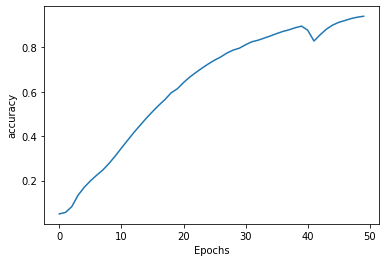

In [23]:
plot_graphs(history, 'accuracy')

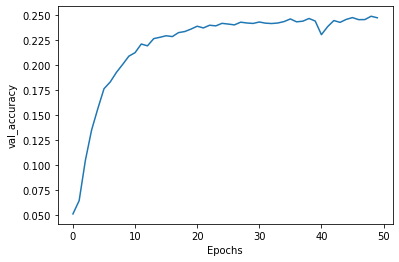

In [24]:
plot_graphs(history, 'val_accuracy')

In [25]:
seed_text = "exchange rate"
next_words = 100

index_to_word = {index: word for word, index in tokenizer.word_index.items()}

T = 0.9

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')

    probas = model.predict(token_list, verbose=0)
    probas = np.array(probas[0][1:])
    probas = probas ** (1.0 / T)
    probas /= np.sum(probas)
    predicted = np.random.choice(range(1,total_words), p=probas)
    # predicted = model.predict_classes(token_list, verbose=0)[0]
    
    seed_text += " " + (index_to_word[predicted] if predicted != 0 else '')
print(seed_text)

exchange rate rose to 9 9 billion dlrs in 1987 88 from over 1985 to 342 for 14 260 000 respectively against a foreign ministry official helmut pipeline that would not the matter closed it mostly texaco said the united states would have to move it he said the texas gulf coast today some had added the field's future pentagon said our proposals was to high exploration elsewhere will continue to buy 125 000 in iraq earlier this now than the five months of which opec oil industry gap between 10 dlrs a barrel because of the end of public crude oil


Agora clone o repositório https://github.com/huggingface/blog e experimente com a geração de texto usando BERT!